In [1]:
import ray
import os,sys
import subprocess
ray.init()
import matplotlib.pyplot as plt
import numpy as np

2021-03-04 10:18:13,495	INFO resource_spec.py:212 -- Starting Ray with 17.24 GiB memory available for workers and up to 8.64 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2021-03-04 10:18:13,808	INFO services.py:1170 -- View the Ray dashboard at localhost:8265


In [2]:
@ray.remote
def run_lora(N_nodes, Interval_ms, Exp_mod, Sim_ms, Collision):
    output = subprocess.getoutput("python3 loraDir.py %d %d %d %d %d" % ((N_nodes, Interval_ms, Exp_mod, Sim_ms, Collision)))
    output = output.splitlines()[-1].split(" ")
    energy, sent, nrCollisions, nrReceived, nrProcessed, der = [float(e) for e in output]
    return energy, sent, nrCollisions, nrReceived, nrProcessed, der

In [3]:
r100 = ray.get([run_lora.remote(N_nodes=100, Interval_ms=200*i, Exp_mod=3, Sim_ms=3600000, Collision=1) for i in range(10,600,1)])
r200 = ray.get([run_lora.remote(N_nodes=200, Interval_ms=400*i, Exp_mod=3, Sim_ms=3600000, Collision=1) for i in range(10,600,1)])
r500 = ray.get([run_lora.remote(N_nodes=500, Interval_ms=1000*i, Exp_mod=3, Sim_ms=3600000, Collision=1) for i in range(10,600,1)])
r1000 = ray.get([run_lora.remote(N_nodes=1000, Interval_ms=2000*i, Exp_mod=3, Sim_ms=3600000, Collision=1) for i in range(10,600,1)])

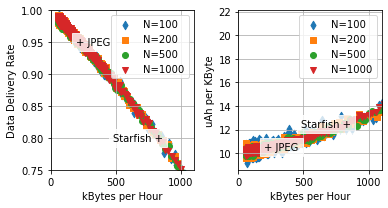

In [5]:
plt.figure(figsize=(5.5,3))

dt = [np.array(r100), np.array(r200), np.array(r500), np.array(r1000)]
lb = ['N=100', 'N=200', 'N=500', 'N=1000']
mk = ['d', 's', 'o', 'v']


plt.subplot(1,2,1)
for i in range(len(dt)):
    r = dt[i]
    plt.scatter( r[:,-3]*20/1000, r[:,-1], label=lb[i], marker=mk[i])
    
plt.ylim([0.75, 1.0])
plt.xlim([0, 1100])
plt.text(219-20, 0.95, "+ JPEG", fontsize=10, bbox=dict(edgecolor= 'white', facecolor='white', alpha=0.8), 
         horizontalalignment='left', verticalalignment='center')
plt.text(825+40, 0.80, "Starfish +", fontsize=10, bbox=dict(edgecolor= 'white', facecolor='white', alpha=0.8), 
         horizontalalignment='right', verticalalignment='center')
plt.grid(); plt.legend()
plt.xlabel('kBytes per Hour')
plt.ylabel('Data Delivery Rate')

plt.subplot(1,2,2)

for i in range(len(dt)):
    r = dt[i]
    plt.scatter( r[:,-3]*20/1000, r[:,0]/r[:,-3]*4200, label=lb[i], marker=mk[i])
#plt.ylim([0.75, 1.0])
plt.xlim([0, 1100])
plt.grid(); plt.legend()
plt.xlabel('kBytes per Hour')
plt.ylabel('uAh per KByte')
plt.text(219-20, 10.5, "+ JPEG", fontsize=10, bbox=dict(edgecolor= 'white', facecolor='white', alpha=0.8), 
         horizontalalignment='left', verticalalignment='center')
plt.text(825+40, 12.5, "Starfish +", fontsize=10, bbox=dict(edgecolor= 'white', facecolor='white', alpha=0.8), 
         horizontalalignment='right', verticalalignment='center')
plt.tight_layout()
plt.savefig("lorasim.pdf")